In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import glob
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

import copy
from astropy.visualization import quantity_support
from astropy.table import Table, QTable
import matplotlib
import astropy.units as u
from astroduet.config import Telescope
from astroduet.background import background_pixel_rate
font = {'size'   : 22}
from astroduet.models import Simulations, fits_file, load_model_ABmag, load_model_fluence
matplotlib.rc('font', **font)
from astroduet.lightcurve import get_lightcurve, lightcurve_through_image
import astroduet.image_utils

In [2]:
## Do it only once
# sims = Simulations()
# sims.parse_emgw()

In [33]:
def create_and_plot_lc(input_lc_file, distance=100e6*u.pc, **kwargs):
    abtime, ab1, ab2 = load_model_ABmag(input_lc_file,
                                        dist=distance)
    model_lc_table_ab = QTable({'time': abtime, 'mag_D1': ab1, 'mag_D2':ab2})
    lightcurve = get_lightcurve(input_lc_file, distance=distance, **kwargs)
    plt.figure(figsize=(15, 8))
    gs = plt.GridSpec(2, 1, hspace=0)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1], sharex=ax0)
    good = (lightcurve['snr_D1'] > 1) | (lightcurve['snr_D2'] > 1)
    lightcurve = lightcurve[good]
    ax0.errorbar(lightcurve['time'].value / 86400, lightcurve['mag_D1'].value, 
                 fmt='o', markersize=2, yerr=lightcurve['mag_D1_err'].value)
    ax0.errorbar(lightcurve['time'].value / 86400, lightcurve['mag_D2'].value, 
                 fmt='o', markersize=2, yerr=lightcurve['mag_D2_err'].value)
    ax1.scatter(lightcurve['time'].value / 86400, lightcurve['snr_D1'].value, s=2)
    ax1.scatter(lightcurve['time'].value / 86400, lightcurve['snr_D2'].value, s=2)
    
    ax0.plot(model_lc_table_ab['time'] / 86400, model_lc_table_ab[f'mag_D1'])
    ax0.plot(model_lc_table_ab['time'] / 86400, model_lc_table_ab[f'mag_D2'])

    ax0.set_ylabel("AB mag")
    ax1.set_ylabel("S/R")
    ax1.set_xlabel("Time (d)")
    ax0.set_xlim([lightcurve['time'][0].value / 86400, lightcurve['time'][-1].value / 86400])
    ymin = min(lightcurve['mag_D1'].value.min(), lightcurve['mag_D2'].value.min()) - 1
    ymax = max(lightcurve['mag_D1'].value.max(), lightcurve['mag_D2'].value.max()) + 1
    # Inverted ax for magnitude
#     ax0.set_ylim([ymax, ymin])
#    ax1.semilogx();
    

/Users/meo/devel/spyder_projects/duet-astro/astroduet/lightcurve.py:277: DeprecationWarning: invalid escape sequence \s
  return lc_snr


/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


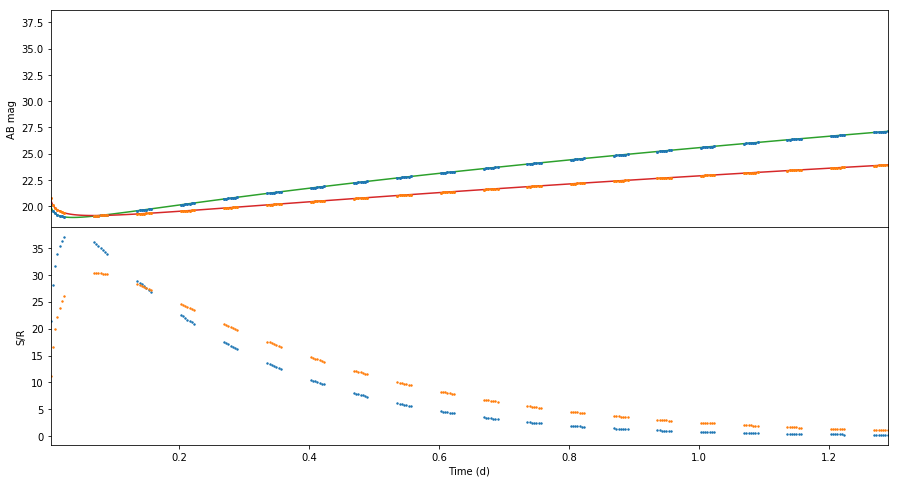

In [34]:
create_and_plot_lc('shock_2.5e10.dat', distance=100e6*u.pc)

Now specifying the observing window...

In [45]:
def plot_realistic_lightcurve(input_lc_file, exposure, label=None, debug=False,  
                              observing_windows=np.array([[0, 30000]]) * u.s, 
                              distance=150e6*u.pc):
    model_lc_table_fl = QTable(load_model_fluence(input_lc_file,
                                                  dist=distance))
    # Set debug to True to dump all intermediate images.
    lightcurve_init = \
        get_lightcurve(input_lc_file, exposure=exposure, observing_windows=observing_windows,
                       distance=distance)
    lightcurve = lightcurve_through_image(lightcurve_init, exposure=exposure, debug=debug)
    lightcurve_rebin = lightcurve_through_image(lightcurve_init, exposure=exposure, 
                                                final_resolution=1200*u.s, debug=debug)
    plt.figure(figsize=(15, 10))
    plt.plot(model_lc_table_fl['time'].value / 86400, 
             model_lc_table_fl['fluence_D1'].to(u.ph / u.cm**2 / u.s).value, label=f"init D1")
    plt.plot(model_lc_table_fl['time'].value / 86400, 
             model_lc_table_fl['fluence_D2'].to(u.ph / u.cm**2 / u.s).value, label=f"init D2")
    for lc, expo in zip([lightcurve, lightcurve_rebin], [exposure, 1200 * u.s]):
        good1 = (lc['fluence_D1_fit'] > 0)&(lc['fluence_D1_fiterr'] < lc['fluence_D1_fit'])
        good2 = (lc['fluence_D2_fit'] > 0)&(lc['fluence_D2_fiterr'] < lc['fluence_D2_fit'])
        good = good1&good2
        plt.errorbar(lc['time'].value[good] / 86400, 
                     lc['fluence_D1_fit'][good].value, 
                     yerr=lc['fluence_D1_fiterr'][good].value, fmt='o', label=f"D1, {expo}")
        plt.errorbar(lc['time'].value[good] / 86400, 
                     lc['fluence_D2_fit'][good].value, 
                     yerr=lc['fluence_D2_fiterr'][good].value, fmt='s', label=f"D2, {expo}")
    plt.xlabel("Time (d)")
    plt.ylabel("Fluence (ph / cm^2 / s)")
    plt.xlim([lightcurve['time'].value.min()/86400, 
              lightcurve['time'].value.max()/86400])
    plt.title(label)
    plt.legend()


/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
100%|██████████| 35/35 [00:16<00:00,  2.18it/s]
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
100%|██████████| 13/13 [00:06<00:00,  2.02it/s]


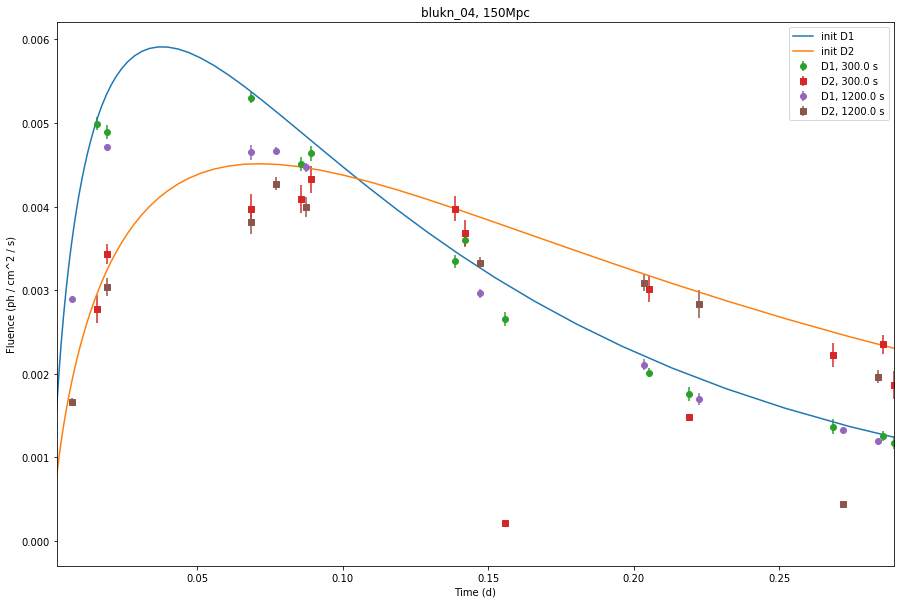

In [46]:
plot_realistic_lightcurve("shock_2.5e10.dat", 300 * u.s, label="blukn_04, 150Mpc", debug=False)

In [ ]:
## In case someone wants to take a look at the debug images...
## set debug=True in plot_realistic_lightcurves and look at them

def plot_debug_images(directory):
    from astroduet.image_utils import find, run_daophot
    img_pickles = glob.glob(os.path.join(directory, '*.p'))
    for img_pickle in img_pickles:
        with open(img_pickle, 'rb') as fobj:
            img = pickle.load(fobj)
        image1 = img['imgD1']
 
        plt.figure(figsize=(10, 10))
        plt.title(img_pickle)
        plt.imshow(image1)
    
# plot_debug_images('debug_imgs_1200.0s_96486629')

/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
100%|██████████| 112/112 [00:49<00:00,  2.26it/s]
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
100%|██████████| 41/41 [00:18<00:00,  2.28it/s]


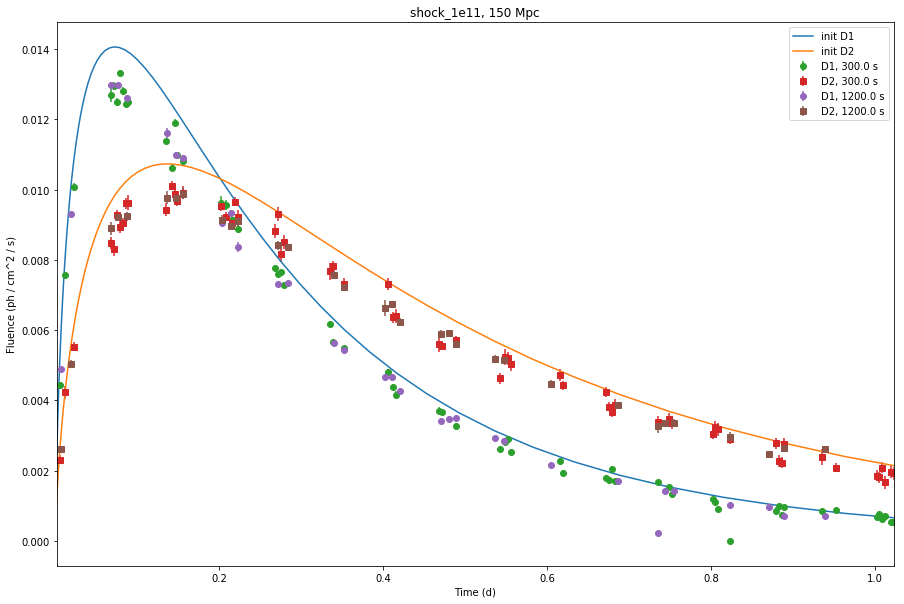

In [50]:
plot_realistic_lightcurve("shock_1e11.dat", exposure=300 * u.s,
                   observing_windows=np.array([[0, 90000]]) * u.s, 
                   distance=150e6*u.pc, 
                   label='shock_1e11, 150 Mpc', debug=False)
